# Reduced version of the Koenig Model

König model from : DOI: 10.1371/journal.pcbi.1002577 

In this notebook we present a reduced version of the konig ODE model.
We have added two reactions for export and import of glucose.
We have added one irreversible reaction that export F16BP

Experimental data are taken from König et al.

In [3]:
#modelbase
from modelbase.ode import Model, Simulator
%matplotlib inline
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

import math
import numpy as np
from pylab import *
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os, os.path
import random
import csv

### Data format and preprocessing

In [6]:
list_data_d = []
with open('tableau_glyco.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        list_data_d.append(row)
 
del list_data_d[0]

list_data_s = []      
with open('glyco_synth.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        list_data_s.append(row)
        #print(', '.join(row))
        
list_data_s = np.asarray(list_data_s).transpose()
list_data_d = np.asarray(list_data_d).transpose()

In [7]:
def format_data(tableau, index):
    time = tableau[2*index]
    concentration = tableau[2*index+1]
    
    time_list = []
    concentration_list = []
    #check for NAN
    i = 0
    for i in range(len(concentration)):

        if time[i] != 'NaN':
            time_list.append(eval(time[i]))
            concentration_list.append(eval(concentration[i]))
    return time_list, concentration_list

### glucose-hormone responses (GHR)

In [8]:
def logistic_hr(x):    
    gamma = 1/(1+np.exp(x-4.6))+0.03
    #gamma = 0.5
    return gamma

global gamma 
gamma = logistic_hr

### glucose export and import

In [9]:
def glucose_export(S,kout): 
    treshold = 1
    k=10
    return  kout*1/(1+np.exp(-2*k*(S-treshold)))

def glucose_import(time,kin,timespent=0):
    k=0.5
    t0 = 5*60
    return kin*1/(1+np.exp(2*k*(time-t0)))

## The model

In [12]:
m = Model()
m.add_compounds(['Glc_plasma','Glc','Glc6P','F6P','Glc1P','UDP-Glc','ATP','ADP','UTP',
                 'UDP','PP','P','glyglc','AMP', 'GTP','GDP','F26BP',
                 'F16BP','DHAP','GRAP','NAD','NADH','BPG13','PG3',
                 'PG2','PEP','PYR','OAA','CO2','OAA_mito','GTP_mito',
                 'PEP_mito','GDP_mito','CO2_mito','PYR_mito', 
                 'ATP_mito','ADP_mito','ACOA_mito','LAC','LAC_ext','COA_mito',
                 'NADH_mito','NAD_mito','CIT_mito','P_mito','F16BP_out'])   

m.add_parameters({'kin':0.,'kout':0.1,'k1_fwd':1,'k1_bkw':1., 'k2':100,'katpin':1,'kutpin':1,'k3':1,
                  'k3r':0.2, 'k4':1,'k5':1, 'k6':0,'k6r':1,'k7':1,'k8':1,'k9':1,'k10':1,'timespent':0,'vin':0.00,
                 'Glc_level':6})

m.add_reaction(
    rate_name = 'v_in',
    function = glucose_import,
    stoichiometry = {'Glc_plasma':1},
    modifiers = ['time'],
    parameters = ['kin','timespent']
    
)

## two ways to go out:
m.add_reaction_from_args(
    rate_name = 'v_out',
    function = glucose_export,
    #dynamic_variables=[],
    stoichiometry = {'Glc_plasma':-1},
    args = ['Glc_plasma','kout']   
)


def rate_function_glut(S,P):
    Km_glc, Keq, vmax = 42, 1, 250  #mM, ,micro mol/min/kg    
    #Km_glc, Keq, vmax = 42, 2, 250
    numerateur = (vmax/Km_glc)*(S-P/Keq)
    denominateur = 1 + S/Km_glc + P/Km_glc 
    return numerateur/denominateur
    
m.add_reaction_from_args(
    rate_name = 'v1',
    function = rate_function_glut,
    stoichiometry= {'Glc_plasma':-1,'Glc':1},
    args = ['Glc_plasma','Glc'],
    reversible=True,
)


def rate_function_gk(S1,S2,F6P):
    vmax = 15
    n_gkrp, k_gkrp_glc, k_gkrp_fru6p, b_gkrp = 2, 15, 0.010, 0.7
    
    gk = (S1**n_gkrp)/(S1**n_gkrp+k_gkrp_glc**n_gkrp)*(1 - (b_gkrp*F6P)/(F6P+k_gkrp_fru6p))
    
    k_m_atp, k_m_glc, n = 0.26, 7.5,1.6
    v = vmax * gk *(S2)/(k_m_atp+S2)*(S1**n)/(S1**n+k_m_glc**n)
    return v

m.add_reaction_from_args(
    rate_name ="v2",                                        
    function = rate_function_gk,                         
    #stoichiometry = {'Glc':-1,'ATP':-1,'Glc6P':1,'ADP':+1},
    stoichiometry = {'Glc':-1,'Glc6P':1},  
    args = ["Glc", "ATP", "F6P"],  
)


def rate_function_g6pc(S):
    vmax= 11.25
    km = 2
    return vmax*S/(km+S)

m.add_reaction_from_args(
    rate_name ="v3",                                        
    function = rate_function_g6pc,                           
    #stoichiometry = {'Glc6P':-1,'Glc':1,'P':1},  
    stoichiometry = {'Glc6P':-1,'Glc':1},
    args = ["Glc6P"],                          
)

def rate_function_gpi(S,P):
    vmax = 250
    #vmax = 1000 #test
    kms,kmp = 0.182, 0.071
    keq = 0.5157

    return vmax/kms*(S-P/keq)/(1+S/kms+P/kmp) 

m.add_reaction_from_args(
    rate_name = 'v4',
    function = rate_function_gpi,
    stoichiometry = {'Glc6P':-1,'F6P':1},
    args = ['Glc6P','F6P'],
    reversible = True,
)

def rate_function_g16pi(S,P):
    vmax=200
    keq=15.7
    kms, kmp = 0.045, 0.67
    return ((vmax/kms)*(S-P/keq))/(1+S/kms +P/kmp )
    
m.add_reaction_from_args(
    rate_name = 'v5',
    function = rate_function_g16pi,
    stoichiometry = {'Glc1P':-1, 'Glc6P':1},
    args = ['Glc1P','Glc6P'],
    reversible = True,
)

def rate_function_ugt(S1, S2, P1, P2):
    vmax = 160
    keq = 0.31
    kmutp = 0.563
    kmglc1p = 0.172
    kmudpglc = 0.049
    kmpp = 0.166
    
    N = vmax/(kmutp*kmglc1p)*(S1*S2-P1*P2/keq)
    D = (1+S2/kmutp)*(1+S1/kmglc1p)+(1+P1/kmudpglc)*(1+P2/kmpp)-1
    
    return N/D


m.add_reaction_from_args(
    rate_name = 'v6',
    function = rate_function_ugt,
#    stoichiometry = {'Glc1P':-1,'UTP':-1,'UDP-Glc':1,'PP':1},
    stoichiometry = {'Glc1P':-1,'UTP':-1,'UDP-Glc':1},
    args = ['Glc1P','UTP','UDP-Glc','PP'],
    reversible = True,
)

def rate_function_gs(S,G6P,P,glc):
    gam = gamma(glc)
    
    k1max = 0.2
    C = 500
    fmax = (1+k1max)*(C-P)/((C-P)+k1max+C)

    vmax =  26.4
    k1dp = 0.224
    k2dp = 0.1504
    k1p = 3.003
    k2p = 0.09029
    
    vdp  = vmax*fmax*S/(S+(k1dp/(k2dp+G6P)))
    vp   = vmax*fmax*S/(S+(k1p/(k2p+G6P)))
    
    return (1-gam)*vdp+gam*vp

m.add_reaction_from_args(
    rate_name='v8',
    function = rate_function_gs,
    stoichiometry = {'UDP-Glc':-1,  'UDP':1, 'glyglc':1 },
    args = ['UDP-Glc','Glc6P','glyglc','Glc_plasma'],
)


import math
def rate_function_gp(S1,S2,P,amp,glc):
    gam = gamma(glc)
    
    vmax=13.6
    k1max = 0.2
    C = 500
    fmax = (1+k1max)*S1/(S1+k1max*C)
    
    kdpbase_amp = 0.03
    kdpmax_amp =0.30
    kdpa_amp = 1.0    
    vdpmax=vmax*fmax*(kdpbase_amp + (kdpmax_amp-kdpbase_amp)*(amp/(amp+kdpa_amp)))
    
    kpiglc = 5.0
    vpmax = vmax*fmax*math.exp(-math.log(2)*glc/kpiglc)
    
    
    kdp_glyc = 4.8 
    kdp_p=300.0
    keq=0.21
    kdp_glc1p=120.0
    
    kp_glyc = 2.7
    kp_p = 5
    kp_glc1p = 2.0
    vdp = (vdpmax/(kdp_glyc*kdp_p)*(S1*S2-P/keq)) / ((1+S1/kdp_glyc)+(1+S2/kdp_p)+(P/kdp_glc1p)-1)
    vp  = (vpmax/(kp_glyc*kp_p))*(S1*S2-P/keq)    / ((1+S1/kp_glyc)+(1+S2/kp_p)+(P/kp_glc1p)-1)

    return (1-gam)*vdp + gam*vp

m.add_reaction_from_args(
    rate_name='v9',
    function = rate_function_gp,
    stoichiometry = {'glyglc':-1, 'Glc1P':1 },
    #stoichiometry = {'glyglc':-1,  'P':-1, 'Glc1P':1 },
    args = ['glyglc','P','Glc1P','AMP','Glc_plasma'],
)


def rate_function_ndkutp(atp, udp, adp, utp):
    keq = 1
    km_atp = 1.33
    km_adp = 0.042
    km_utp = 16.0
    km_udp = 0.19
    vmax = 1750
    
    return (vmax/(km_atp*km_udp)*(atp*udp-adp*utp/keq)) /( (1+atp/km_atp)*(1+udp/km_udp)+(1+adp/km_adp)*(1+utp/km_utp) -1 )

m.add_reaction_from_args(
    rate_name = 'v11',
    function = rate_function_ndkutp,
    stoichiometry = {'UDP':-1,'UTP':+1},
    #stoichiometry = {'ATP':-1,'UDP':-1,'ADP':+1,'UTP':+1},
    args = ['ATP','UDP','ADP','UTP'],
    reversible = True,
)


def rate_function_ndkgtp(atp, gdp, adp, gtp):
    keq = 1
    km_atp = 1.33
    km_adp = 0.042
    km_gtp = 0.15
    km_gdp = 0.031
    vmax = 1750
    
    return (vmax/(km_atp*km_gdp)*(atp*gdp-adp*gtp/keq)) /( (1+atp/km_atp)*(1+gdp/km_gdp)+(1+adp/km_adp)*(1+gtp/km_gtp) -1 )


def rate_function_pfk2(f6p,atp,glc):
    gam = gamma(glc)
    
    ndp = 1.3
    np  = 2.1
    kdp_f6p = 0.016
    kp_f6p  = 0.050
    kdp_atp = 0.28
    kp_atp = 0.65
    
    
    vdpmax = 0.0025
    vpmax = 0.0025
    
    vdp = vdpmax  * (f6p**ndp/ (f6p**ndp+kdp_f6p**ndp)) * (atp/(atp+kdp_atp))
    vp  = vpmax   * (f6p**np / (f6p**np+kp_f6p**np))     * (atp/(atp+kp_atp))
    
    return (1-gam)*vdp + gam *vp

m.add_reaction_from_args(
    rate_name = 'v13',
    function = rate_function_pfk2,
    #stoichiometry = {'ATP':-1, 'F6P':-1, 'ADP': 1, 'F26BP':1},
    stoichiometry = {'F6P':-1, 'F26BP':1},
    args = ['F6P', 'ATP','Glc'],
    reversible = True,

)

def rate_function_fbp2(f6p,f26bp,glc):
    gam = gamma(glc)
    
    kidp_f6p=0.0035
    kip_f6p = 0.010
    
    kmdp_f26bp = 0.010
    kmp_f26bp  =0.0005
    vmax = 0.075
    
    vdp = vmax /(1+f6p/kidp_f6p) * (f26bp/(kmdp_f26bp+f26bp))
    vp  = vmax  /(1+f6p/kip_f6p)  * (f26bp/(kmp_f26bp +f26bp))
    
    v = (1-gam)*vdp + gam*vp
    return v

m.add_reaction_from_args(
    rate_name = 'v14',
    function = rate_function_fbp2,
    #stoichiometry = {'F26BP':-1,'P':1,'F6P':1},
    stoichiometry = {'F26BP':-1,'F6P':1},
    args = ['F6P', 'F26BP','Glc'],

)

def rate_function_pfk1(f6p,atp,f26bp):
    ka_f26bp = 0.001
    ki_f6p = 0.012
    km_atp = 0.111
    km_f6p = 0.077
    vmax = 0.525
    return vmax * (1+f26bp/ka_f26bp) * (f6p*atp/(ki_f6p*km_atp + km_f6p*atp + km_atp*f6p+atp*f6p    ))


m.add_reaction_from_args(
    rate_name='v15',
    function = rate_function_pfk1,
    #stoichiometry = {'ATP':-1, 'F6P': -1,'F16BP':1,'ADP':1},
    stoichiometry = {'F6P': -1, 'F16BP':1},
    args = ['F6P', 'ATP', 'F26BP'],
)

def rate_function_fbp1(f16bp,f26bp):
    vmax = 2.575 
    ki_f26bp = 0.001
    km_f16bp = 0.0013
    return (vmax/(1+f26bp/ki_f26bp)) * (f16bp/(f16bp+km_f16bp))

m.add_reaction_from_args(
    rate_name = 'v16',
    function = rate_function_fbp1,
    #stoichiometry = {'F16BP':-1,'F6P':1,'P':1},
    stoichiometry = {'F16BP':-1,'F6P':1},
    args = ['F16BP','F26BP'],

)

def rate_function_ald(S,P):    
    vmax = 250
    Keq=10
    v = vmax*(S-P/Keq)
    return v

m.add_reaction_from_args(
    rate_name = 'v17',
    function = rate_function_ald,
    stoichiometry = {'F16BP':-1,'F16BP_out':0},
    args = ['F16BP','F16BP_out'],
    reversible = False,
)




## Reproduction of glycogen degradation

In [17]:
C0 = {'Glc_plasma':5,'Glc':5.,'Glc6P':0.12, 'F6P':0.05,'Glc1P':0.012,'UDP-Glc':0.38,'ATP':2.8,'ADP':0.8,'UTP':0.27,
      'UDP':0.09,'PP':0.008, 'P':5, 'glyglc':500, 'AMP':0.16, 'GTP':0.29,
      'GDP':0.10,'F26BP':0.004,'F16BP':0.02,'DHAP':0.03,'GRAP':0.1,
      'NAD':1.22,'NADH':0.00056,'BPG13':0.3,'PG3':0.27,'PG2':0.03,
      'PEP':0.15,'PYR':0.1,'OAA':0.01,'CO2':5,'OAA_mito':0.01,
      'GTP_mito':0.29,'PEP_mito':0.15,'GDP_mito':0.10,'CO2_mito':5,
      'PYR_mito':0.1,'ATP_mito':2.8,'ADP_mito':0.8,'ACOA_mito':0.04,
      'LAC':0.5,'LAC_ext':1.2,'COA_mito':0.055,'NADH_mito':0.24,
      'NAD_mito':0.98,'CIT_mito':0.32,'P_mito':5.0,'F16BP_out':0.0}
m.add_parameters({'kin':0.,'kout':0.1,'k1_fwd':1,'k1_bkw':1., 'k2':100,'katpin':1,'kutpin':1,'k3':1,
                  'k3r':0.2, 'k4':1,'k5':1, 'k6':0,'k6r':1,'k7':1,'k8':1,'k9':1,'k10':1,'timespent':0,'vin':0.00,
                 'Glc_level':6})
  
s = Simulator(m)
s.initialise(C0)
t,c = s.simulate(3600)

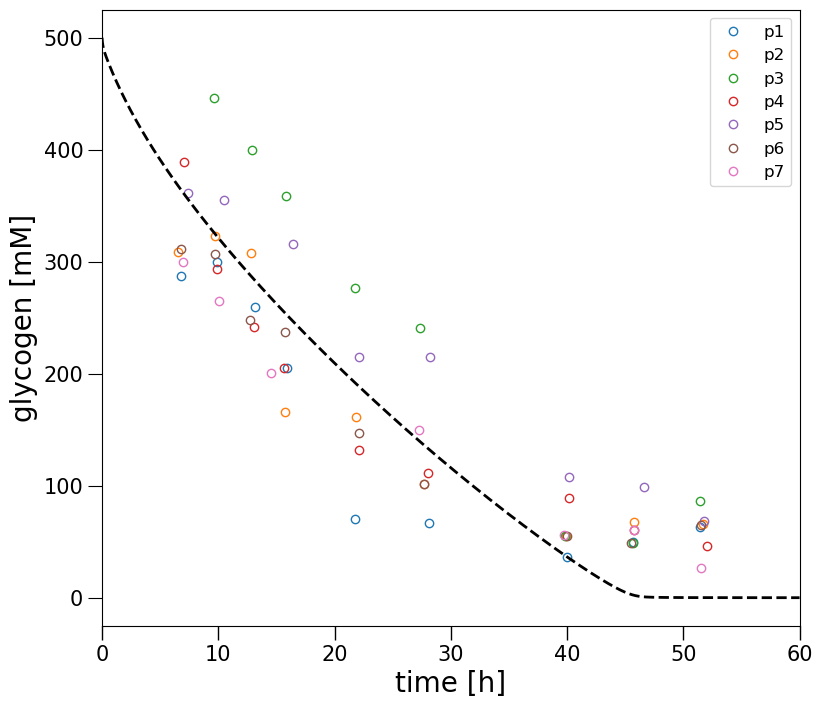

In [18]:
concentrations = c.transpose()
tsaved,csaved = copy.deepcopy(t),copy.deepcopy(c)


x1,y1=format_data(list_data_d,0)
x2,y2=format_data(list_data_d,1)
x3,y3=format_data(list_data_d,2)
x4,y4=format_data(list_data_d,3)
x5,y5=format_data(list_data_d,4)
x6,y6=format_data(list_data_d,5)
x7,y7=format_data(list_data_d,6)

plt.figure(figsize=(9,8))
#plt.plot(t,concentrations[0])
#plt.ylim([0,10])
plt.plot(x1,y1, 'o',fillstyle='none', label = 'p1')
plt.plot(x2,y2, 'o',fillstyle='none', label = 'p2')
plt.plot(x3,y3, 'o',fillstyle='none', label = 'p3')
plt.plot(x4,y4, 'o',fillstyle='none', label = 'p4')
plt.plot(x5,y5, 'o',fillstyle='none', label = 'p5')
plt.plot(x6,y6, 'o',fillstyle='none', label = 'p6')
plt.plot(x7,y7, 'o',fillstyle='none', label = 'p7')
plt.xlim([0,t[-1]/60])
plt.plot(np.asarray(t)/60,concentrations[12], lw = 2, ls='--', color = 'black')
plt.xlabel('time [h]',fontsize = 20)
#plt.plot(np.asarray(t)/10,concentrations[])
plt.ylabel('glycogen [mM]',fontsize = 20)
plt.tick_params(axis='x', length=10, width= 1,labelsize=15)
plt.tick_params(axis='y', length=10,labelsize=15)
plt.legend(fontsize=12)
plt.show()
plt.show()

## Reproduction of glycogen synthesis

In [23]:
C0 = {'Glc_plasma':5,'Glc':5.,'Glc6P':0.12, 'F6P':0.05,'Glc1P':0.012,'UDP-Glc':0.38,'ATP':2.8,'ADP':0.8,'UTP':0.27,
      'UDP':0.09,'PP':0.008, 'P':5, 'glyglc':200, 'AMP':0.16, 'GTP':0.29,
      'GDP':0.10,'F26BP':0.004,'F16BP':0.02,'DHAP':0.03,'GRAP':0.1,
      'NAD':1.22,'NADH':0.00056,'BPG13':0.3,'PG3':0.27,'PG2':0.03,
      'PEP':0.15,'PYR':0.1,'OAA':0.01,'CO2':5,'OAA_mito':0.01,
      'GTP_mito':0.29,'PEP_mito':0.15,'GDP_mito':0.10,'CO2_mito':5,
      'PYR_mito':0.1,'ATP_mito':2.8,'ADP_mito':0.8,'ACOA_mito':0.04,
      'LAC':0.5,'LAC_ext':1.2,'COA_mito':0.055,'NADH_mito':0.24,
      'NAD_mito':0.98,'CIT_mito':0.32,'P_mito':5.0,'F16BP_out':0.0}

m.add_parameters({'kin':0.8,'kout':0.,'k1_fwd':1,'k1_bkw':1., 'k2':100,'katpin':1,'kutpin':1,'k3':1,
                  'k3r':0.2, 'k4':1,'k5':1, 'k6':0,'k6r':1,'k7':1,'k8':1,'k9':1,'k10':1,'timespent':0,'vin':0.00,
                 'Glc_level':6})
  
s = Simulator(m)
s.initialise(C0)
t,c = s.simulate(60*4.5)
concentrations = c.transpose()

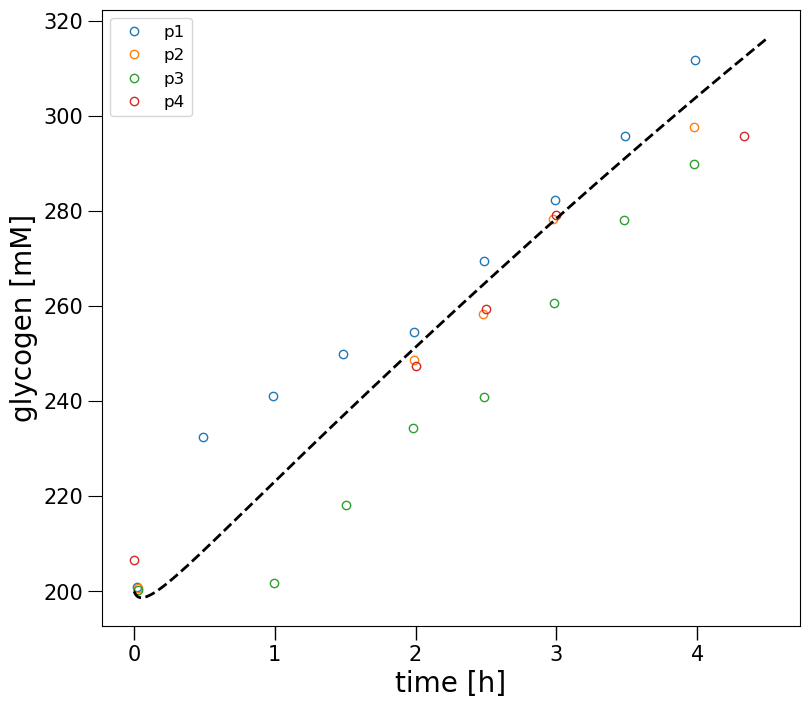

In [24]:
x1,y1=format_data(list_data_s,0)
x2,y2=format_data(list_data_s,1)
x3,y3=format_data(list_data_s,2)
x4,y4=format_data(list_data_s,3)


plt.figure(figsize=(9,8))

plt.plot(np.asarray(x1)/60,y1, 'o',fillstyle='none', label = 'p1')
plt.plot(np.asarray(x2)/60,y2, 'o',fillstyle='none', label = 'p2')
plt.plot(np.asarray(x3)/60,y3, 'o',fillstyle='none', label = 'p3')
plt.plot(np.asarray(x4)/60,y4, 'o',fillstyle='none', label = 'p4')

plt.plot(np.asarray(t)/60,concentrations[12], lw = 2, ls='--', color = 'black')
plt.xlabel('time [h]',fontsize = 20)

plt.ylabel('glycogen [mM]',fontsize = 20)
plt.tick_params(axis='x', length=10, width= 1,labelsize=15)
plt.tick_params(axis='y', length=10,labelsize=15)
plt.legend(fontsize=12)
plt.show()
plt.show()